In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"isratanika","key":"3a7c473846fd270574def603f8096410"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d grassknoted/asl-alphabet


Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
 98% 1.01G/1.03G [00:08<00:00, 99.9MB/s]
100% 1.03G/1.03G [00:08<00:00, 131MB/s] 


In [5]:
!unzip asl-alphabet.zip -d ./asl_dataset


Streaming output truncated to the last 5000 lines.
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: ./asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: ./asl_dataset/asl_alphabet_tr

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Settings
IMG_SIZE = 224
BATCH_SIZE = 32
DATASET_PATH = "./asl_dataset/asl_alphabet_train/asl_alphabet_train"

# ✅ Data Augmentation and Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Split 20% for validation
)

# ✅ Training Data Generator
train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# ✅ Validation Data Generator
val_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# ✅ Number of Classes
num_classes = len(train_generator.class_indices)

print(f"✅ Number of classes: {num_classes}")
print(f"✅ Training samples: {train_generator.samples}")
print(f"✅ Validation samples: {val_generator.samples}")


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
✅ Number of classes: 29
✅ Training samples: 69600
✅ Validation samples: 17400


In [7]:
# ✅ Convert generators to tf.data.Dataset for small batch handling
train_ds = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
    )
).batch(32).shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
    )
).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision

# ✅ Enable Mixed Precision for T4 GPU Optimization
mixed_precision.set_global_policy('mixed_float16')

# ✅ Settings
IMG_SIZE = 224
BATCH_SIZE = 32
DATASET_PATH = "./asl_dataset/asl_alphabet_train/asl_alphabet_train"


In [9]:
# ✅ Load Dataset and Split into Small Batches
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    label_mode='categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42,
    shuffle=True
)

# ✅ Save class_names BEFORE prefetching!
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"✅ Number of classes: {num_classes}")

# ✅ Now Apply Prefetch
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
# ✅ Adjust Steps per Epoch (2700 total steps)
steps_per_epoch = 2700 // BATCH_SIZE
validation_steps = len(val_ds) // BATCH_SIZE


Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
✅ Number of classes: 29


In [10]:
from tensorflow.keras.applications import VGG16

# ✅ Load Pretrained VGG16 Model (Frozen Base)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

# ✅ Define the Model
model_vgg = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')  # ✅ Use saved num_classes
])

# ✅ Compile Model
model_vgg.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Summary
model_vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 29)                  │           7,453 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,853,469 (56.66 MB)

 Trainable params: 138,781 (542.11 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
!find . -name '.DS_Store' -type f -delete


In [11]:
# ✅ Early Stopping to Avoid Overfitting
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history_vgg = model_vgg.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 158s 65ms/step - accuracy: 0.6878 - loss: 1.4734 - val_accuracy: 0.9878 - val_loss: 0.0521
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 178s 61ms/step - accuracy: 0.9541 - loss: 0.1392 - val_accuracy: 0.9878 - val_loss: 0.0408
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 145s 67ms/step - accuracy: 0.9646 - loss: 0.1036 - val_accuracy: 0.9911 - val_loss: 0.0266
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 146s 67ms/step - accuracy: 0.9671 - loss: 0.0922 - val_accuracy: 0.9913 - val_loss: 0.0257
Epoch 5/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 187s 60ms/step - accuracy: 0.9730 - loss: 0.0771 - val_accuracy: 0.9911 - val_loss: 0.0265
Epoch 6/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 145s 67ms/step - accuracy: 0.9767 - loss: 0.0675 - val_accuracy: 0.9939 - val_loss: 0.0181
Epoch 7/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 131s 60ms/step - accuracy: 0.9778 - loss: 0.0666 - val_accuracy: 0.9929 - val_loss: 0.0222
Epoch 8/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 142s 60ms/step - accuracy: 

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Step 1: Define Evaluation Metrics
def compute_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1-score": f1
    }

print("✅ Evaluation Metrics Defined!")

# ✅ Step 2: Define Evaluation Class for VGG Model
class VGGEvaluator:
    def __init__(self, model, val_ds):
        self.model = model
        self.val_ds = val_ds

    def evaluate(self):
        print("\n🔍 Evaluating VGG Model...")

        y_true = []
        y_pred = []

        for images, labels in self.val_ds:
            logits = self.model.predict(images, verbose=0)
            predictions = np.argmax(logits, axis=-1)

            y_true.extend(np.argmax(labels.numpy(), axis=-1))  # Convert one-hot to label index
            y_pred.extend(predictions)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # ✅ Compute Metrics
        metrics = compute_metrics(y_true, y_pred)

        print("\n✅ FINAL MODEL RESULTS ✅")
        for key, value in metrics.items():
            print(f"{key}: {value:.5f}")

        return metrics

# ✅ Step 3: Run Evaluation for VGG Model
if 'model_vgg' in locals():
    evaluator = VGGEvaluator(model_vgg, val_ds)
    eval_results = evaluator.evaluate()

    # ✅ Save Model
    from google.colab import drive
    drive.mount('/content/drive')

    model_vgg.save('/content/drive/MyDrive/asl_vgg_model.h5')
    print("✅ VGG Model saved to Google Drive!")

✅ Evaluation Metrics Defined!

🔍 Evaluating VGG Model...

✅ FINAL MODEL RESULTS ✅
accuracy: 0.99615
precision: 0.99619
recall: 0.99615
f1-score: 0.99615


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ VGG Model saved to Google Drive!


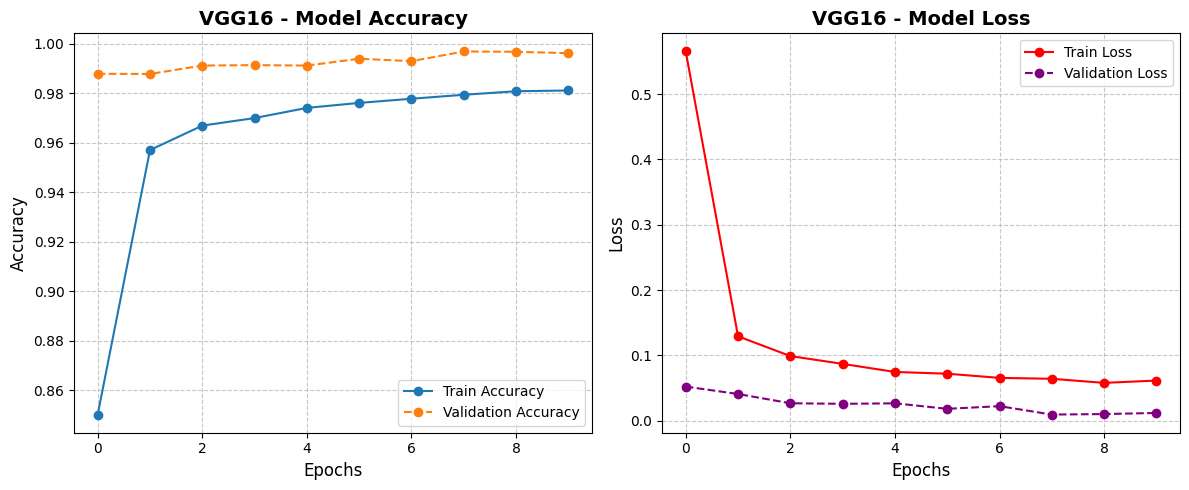

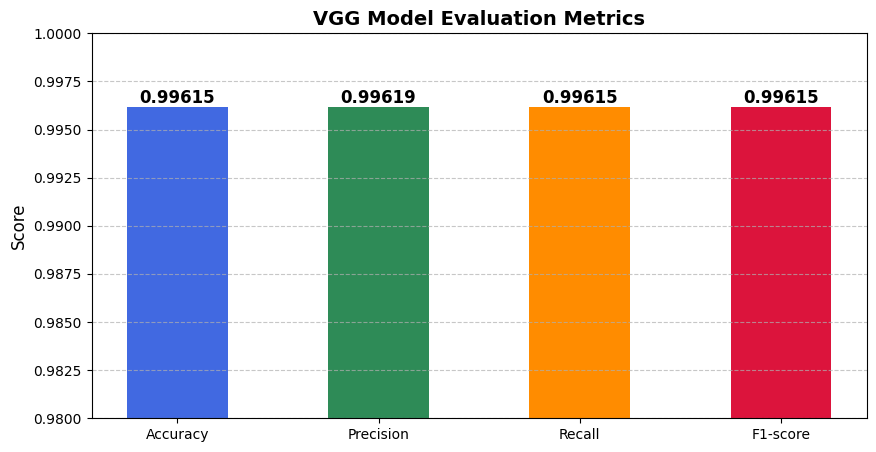

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# ✅ Define evaluation metrics for VGG Model
eval_metrics_vgg = {
    "Accuracy": 0.99615,
    "Precision": 0.99619,
    "Recall": 0.99615,
    "F1-score": 0.99615
}

# ✅ Function to plot training accuracy & loss for VGG Model
def plot_vgg_training_history(history, model_name="VGG"):
    plt.figure(figsize=(12, 5))

    # ✅ Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o', linestyle='-')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o', linestyle='--')
    plt.title(f'{model_name} - Model Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # ✅ Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o', linestyle='-', color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', linestyle='--', color='purple')
    plt.title(f'{model_name} - Model Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# ✅ Function to plot VGG model evaluation metrics
def plot_vgg_eval_metrics(metrics):
    plt.figure(figsize=(10, 5))

    metric_names = list(metrics.keys())
    metric_values = list(metrics.values())
    colors = ["royalblue", "seagreen", "darkorange", "crimson"]

    bars = plt.bar(metric_names, metric_values, color=colors, width=0.5)
    plt.ylabel("Score", fontsize=12)
    plt.ylim(0.98, 1.0)  # Adjust y-axis for better visualization
    plt.title("VGG Model Evaluation Metrics", fontsize=14, fontweight="bold")

    # ✅ Display values on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.5f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# ✅ Plot training accuracy & loss (if VGG model training history exists)
if 'history_vgg' in locals():
    plot_vgg_training_history(history_vgg, model_name="VGG16")

# ✅ Plot Accuracy, Precision, Recall & F1-score together for VGG
plot_vgg_eval_metrics(eval_metrics_vgg)
